# 生成供查询股票列表

In [9]:
import time
import requests
import json
import pandas as pd 
import os
import openpyxl
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams["font.family"] = 'Arial Unicode MS'

查询日期： 2021-04-23
查询数据成功！


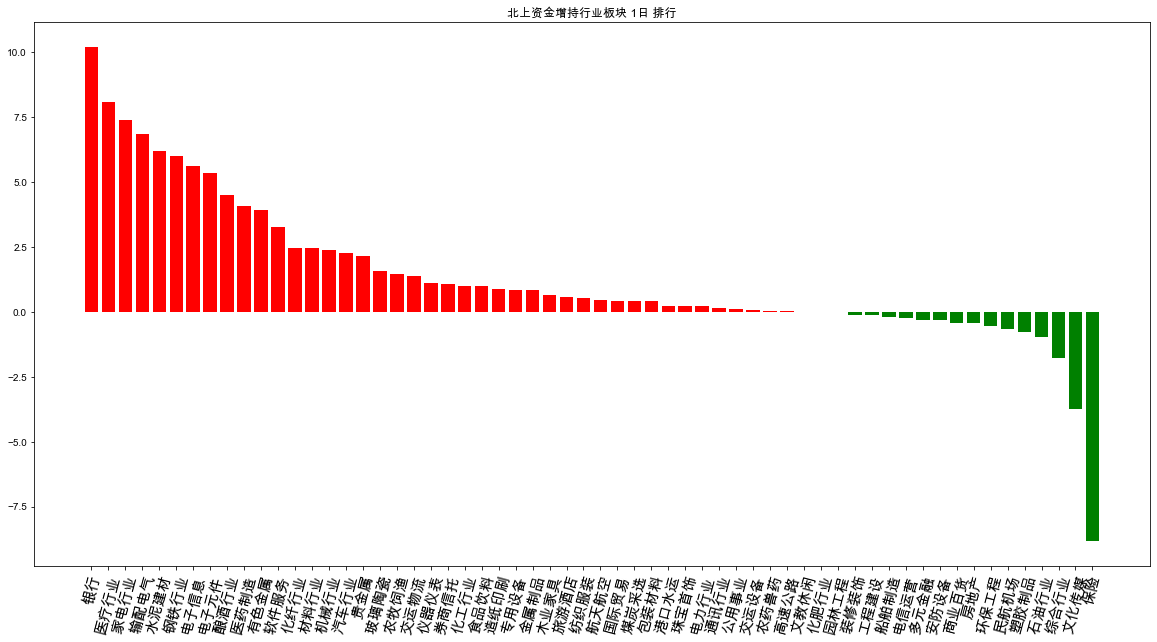

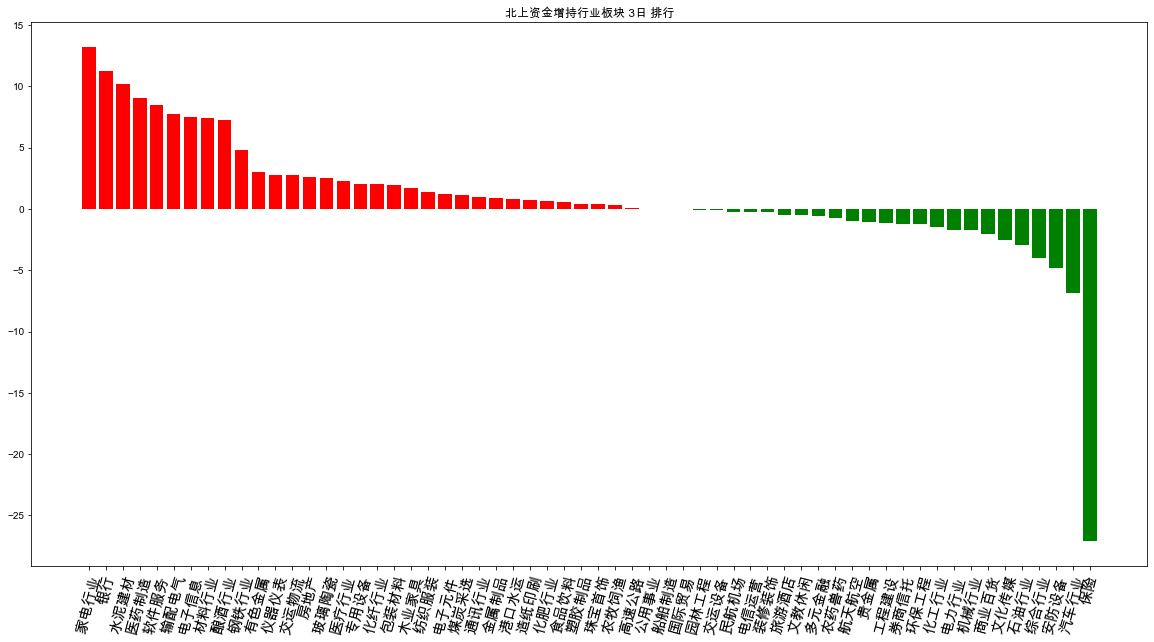

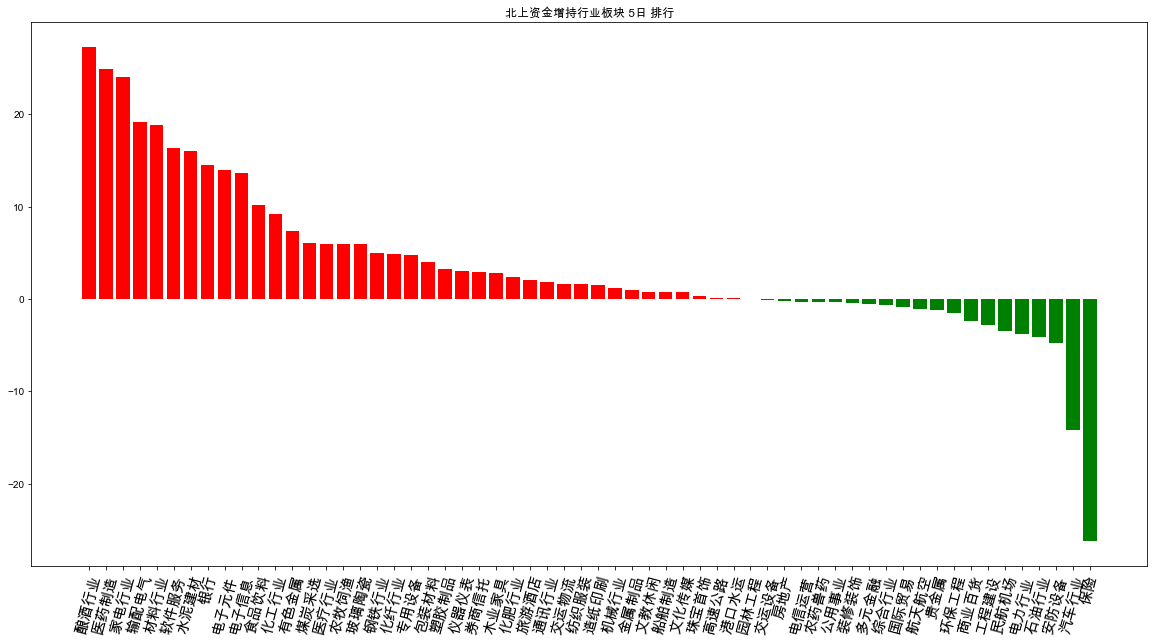

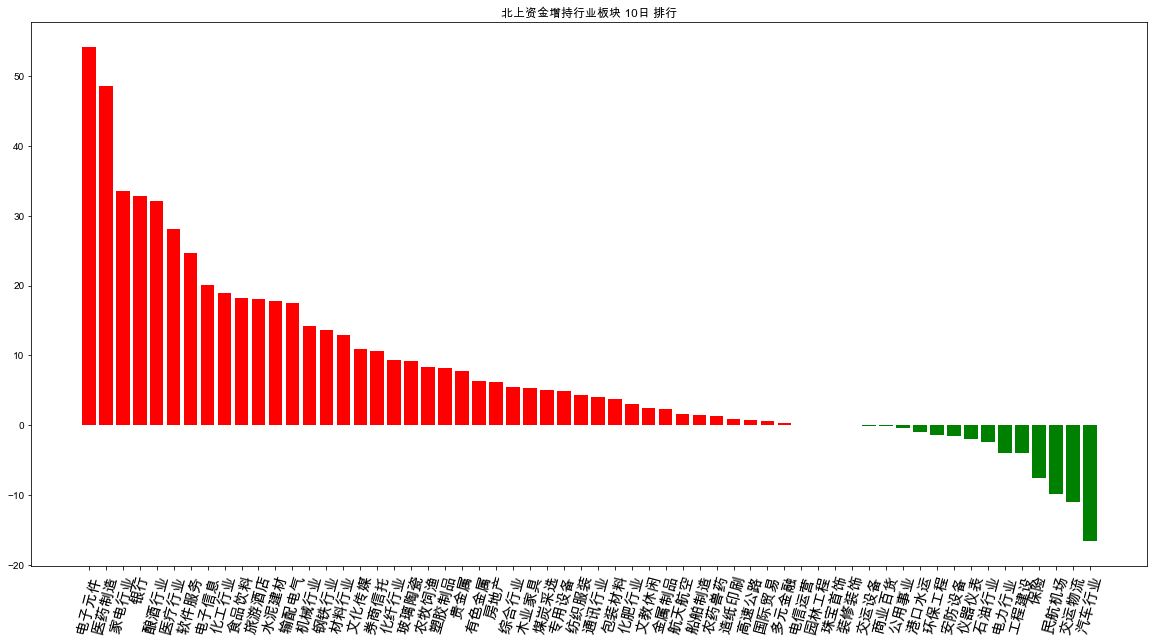

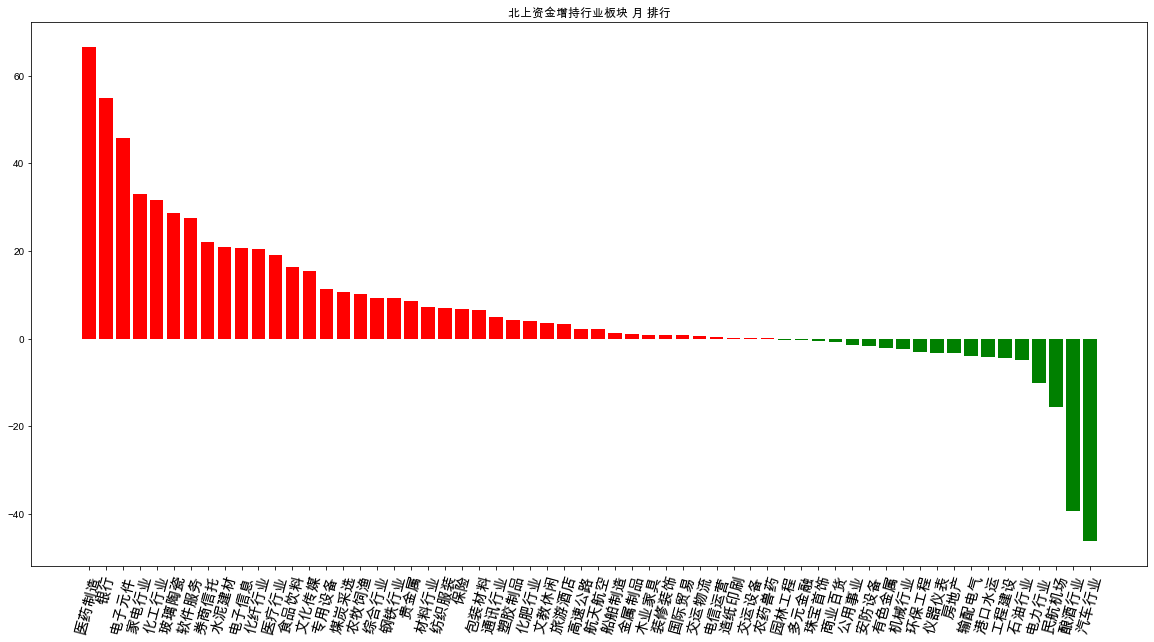

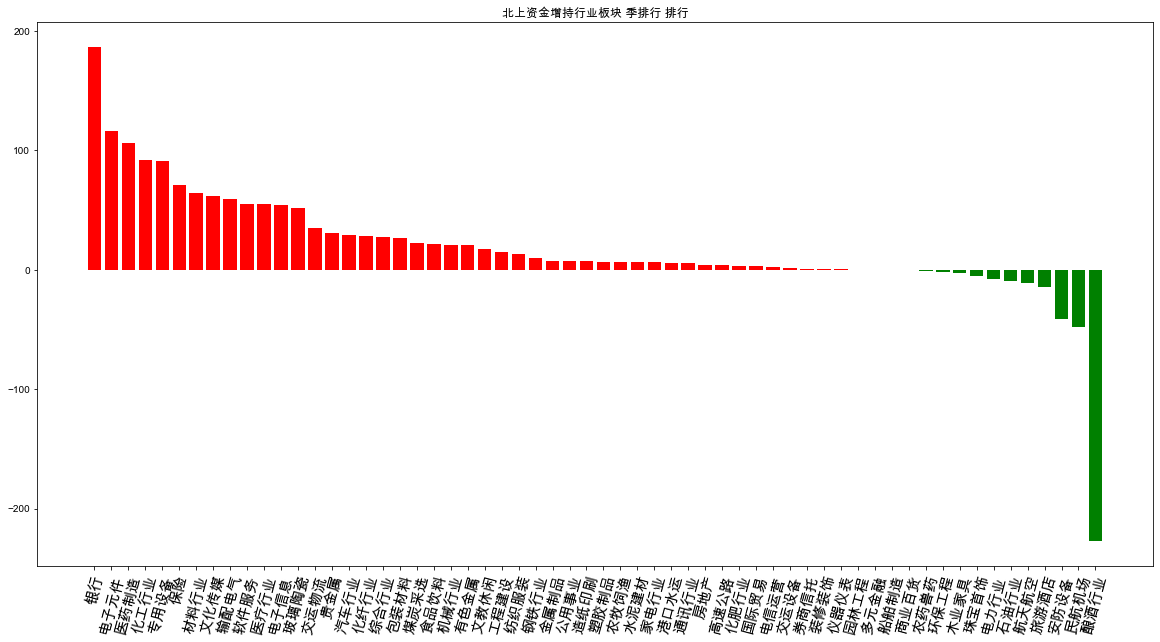

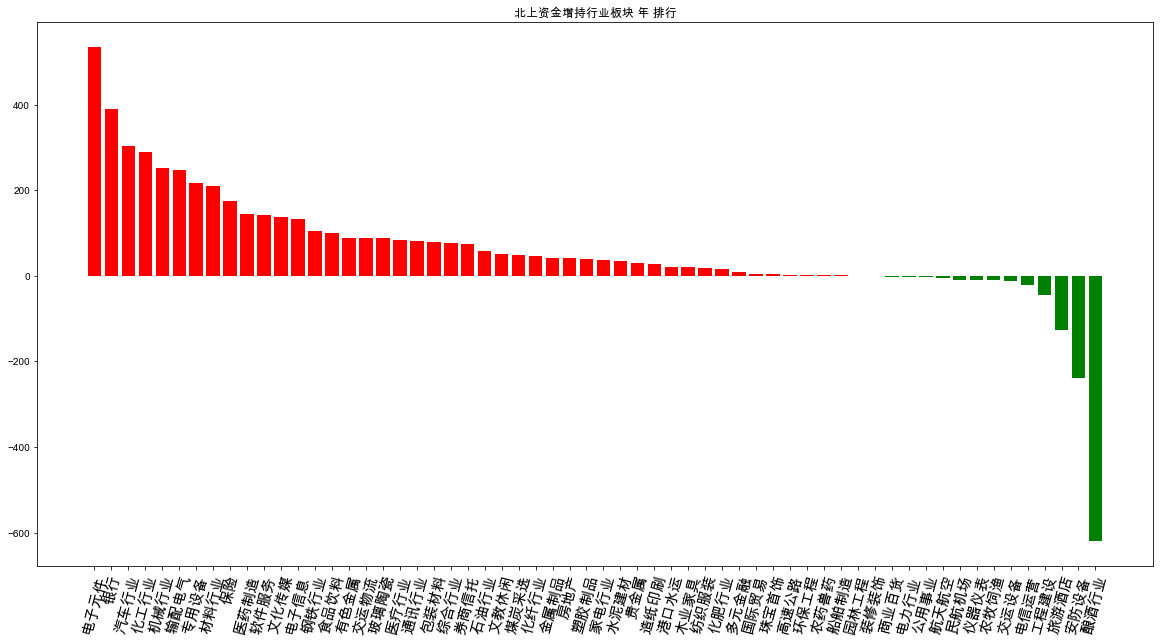

In [10]:
generate_reports()

In [1]:
def generate_reports():
    date = get_latest_date()
    print('查询日期：',date)
    print('查询数据成功！')

    search_types = ["1","3","5","10","m","jd","y"]
    for search_type in search_types:
        north_data = get_daily_north_datasets(date, search_type)
        df = pd.DataFrame(north_data)
        # 画柱状图
        generate_bar_chart(df=df, search_type=search_type)
        # 处理数据
        df = organization_data(df)
        # 保存
        save_data_to_excel(file_name='行业资金流入情况', df=df ,search_type=search_type, date=date)


In [2]:
# 获取最近可查询日期
def get_latest_date():
    time_stamp = time_stamp = int(time.time() * 1000 )
    url = "http://dcfm.eastmoney.com/EM_MutiSvcExpandInterface/api/js/get?type=HSGT20_GZJME_LS_MX&filter=(DateType='y')&token=894050c76af8597a853f5b408b759f5d&st=TradeDate&sr=-1&ps=1&_={}".format(time_stamp)
    response = requests.get(url=url)
    if response.status_code == 200:
        response_json = response.json()
        if type(response_json) is list and len(response_json) > 0:
            if 'TradeDate' in  response_json[0]:
                return  response_json[0]['TradeDate']
        else:
            print('获取数据失败！请重试！')

In [3]:
# 获取每日行业板块北上持仓情况
def get_daily_north_datasets(date, search_type):
    time_stamp = time_stamp = int(time.time() * 1000 )
    url = "http://dcfm.eastmoney.com/em_mutisvcexpandinterface/api/js/get?type=HSGT20_HYTJ_SUM&st=ShareSZ_ZC&sr=-1&token=894050c76af8597a853f5b408b759f5d&p=1&ps=100&filter=(DateType='{}')&_={}".format(search_type,time_stamp)
    response = requests.get(url=url)
    if response.status_code == 200:
        response_json = response.json()
        if type(response_json) is list and len(response_json) > 0:
            return response_json
        else:
            print('获取数据失败！请重试！')
    else:
        print('获取数据失败！请重试！')


In [4]:
def generate_bar_chart(df, search_type, sort_key='ShareSZ_ZC',):
    # 排序 
    #今日增持排序-市值
    plt.figure(figsize=(20,10))
    sort_df = df.sort_values(sort_key, ascending=False)
    sort_df[sort_key] = (sort_df[sort_key]/100000000).round(2)
    colors = [ 'r' if i>0 else 'g'  for i in sort_df[sort_key]]
    plt.bar(sort_df['HYName'],sort_df[sort_key], color=colors)
    plt.xticks(rotation=75, fontsize=15)
    plt.title('北上资金增持行业板块 {} 排行'.format(get_search_type_name(search_type)))
    plt.show()


In [5]:
def get_search_type_name(search_type):
    dic = {
        "1":"1日",
        "3":"3日",
        "5":"5日",
        "10":"10日",
        "m":"月",
        "jd":"季排行",
        "y":"年",
    }
    return dic[search_type]

In [6]:
# 处理数据
def organization_data(df):
    #今日持股 
    df['ShareSZ_GZ'] = (df['ShareSZ_GZ']/100000000).round(2).astype('str')+'亿'
    df['ShareHold_Chg_BK'] = (df['ShareHold_Chg_BK']*100).round(2).astype('str')+'%'
    df['ShareHold_Chg_GZ'] = (df['ShareHold_Chg_GZ']*100).round(2).astype('str')+'%'
    # # 增持
    df['ShareSZ_ZC'] = (df['ShareSZ_ZC']/100000000).round(3).astype('str')+'亿'
    df['ShareHold_ZC_Chg'] = (df['ShareHold_ZC_Chg']*100).round(2).astype('str')+'%'
    df['ShareHold_ZC_Chg_BK'] = (df['ShareHold_ZC_Chg_BK']*1000).round(2).astype('str')+'‰'
    df['ShareHold_ZC_Chg_GZ'] = (df['ShareHold_ZC_Chg_GZ']*1000).round(2).astype('str')+'‰'

    filter_cols = ['HYName', 
                'Zdf', 
                'Count', 
                'ShareSZ_GZ',
                'ShareHold_Chg_BK',
                'ShareHold_Chg_GZ',
                'ZC_Count',
                'ShareSZ_ZC',
                'ShareHold_ZC_Chg',
                'ShareHold_ZC_Chg_BK',
                'ShareHold_ZC_Chg_GZ',
                'Max_SZ_Name',
                'Max_ZB_Name',
                'Min_SZ_Name',
                'Min_ZB_Name',
                ]
    filter_cols_ch = [['', 
                        '', 
                        '北向资金今日持股',
                        '北向资金今日持股',
                        '北向资金今日持股',
                        '北向资金今日持股',
                        '北向资金今日增持估计',
                        '北向资金今日增持估计',
                        '北向资金今日增持估计',
                        '北向资金今日增持估计',
                        '北向资金今日增持估计',
                        '今日增持最大',
                        '今日增持最大',
                        '今日减持最大股',
                        '今日减持最大股'
    ],
    ['行业', 
                        '最新涨跌幅', 
                        '支数',
                        '市值',
                        '占板块比',
                        '占北向资金比',
                        '股票支数',
                        '市值',
                        '市值增幅',
                        '占板块比',
                        '占北向资金比',
                        '市值',
                        '占股本比',
                        '市值',
                        '占股本比'
    ]]
    # 替换索引
    df = df[filter_cols]
    df.columns = filter_cols_ch

    return df

In [7]:
def save_data_to_excel(file_name, df, search_type, date):
    root_path = "excels"
    date = date
    date_path = os.path.join(root_path,date)
    file_path = os.path.join(date_path, get_search_type_name(search_type) + file_name+'.xlsx')
    
    #判断文件夹是否存在
    if os.path.exists(root_path) is False:
        os.mkdir(root_path)
    if os.path.exists(date_path) is False:
        os.mkdir(date_path)
    # 保存北上数据
    df.to_excel(file_path)
